# PLANET by hand

In [1]:
from sklearn.datasets import make_regression
from matplotlib import pyplot
import numpy as np
import pandas as pd


In [11]:
# generate regression dataset
X, y = make_regression(n_samples=6, n_features=2 , noise=0.1, random_state=2020)

In [49]:
df=pd.DataFrame(zip(X,y), columns=["X","y"])
df[['x0','x1']] = pd.DataFrame(df["X"].values.tolist(), index= df.index)
df=df.drop(['X'], axis=1)
df=df.round(1)
df

,y,x0,x1
0,60.2,-0.8,1.3
1,-82.1,-1.1,-0.7
2,-55.3,-1.8,0.1
3,2.1,-0.1,0.1
4,-115.5,-0.9,-1.3
5,-24.2,0.4,-0.6


## PLANET
https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/36296.pdf

1. Preprocess: generate split points

2. Controller: 
        broadcast splits points
        broadcast model file
        broadcast N (list of nodes to expand)
        
3. Mapper:
       
       Algorithm 2 MR ExpandNodes::Map
        Require: NodeSet N, ModelFile M, Training record
        (x, y) ∈ D∗
        1: n = TraverseTree(M, x)
        2: if n ∈ N then
        3:    agg tupn ← y
        4:    for all X ∈ X do
        5:       v = Value on X in x
        6:       if X is ordered then
        7:          for all Split point s of X s.t. s < v do
        8:             Tn,X [s] ← y
        9:       else
        10:         Tn,X [v] ← y
4. Mapper Final:
        
        Algorithm 3 MR ExpandNodes::Map Finalize
        Require: NodeSet N
        1: for all n ∈ N do
        2:    Output to all reducers(agg tupn)
        3: for all X ∈ X do
        4:    if X is ordered then
        5:       for all Split point s of X do
        6:          Output((n, X, s), Tn,X [s])
        7:    else
        8:       for all v ∈ Tn,X do
        9:          Output((n, X), (v, Tn,X [v]))
        
5. Reducer:
        
        Algorithm 4 MR ExpandNodes::Reduce
        Require: Key k,Value Set V
        1: if k == n then
        2:    {Aggregate agg tupn’s from mappers}
        3:    agg tupn = Aggregate(V )
        4: else if k == n, X, s then
        5:    {Split on ordered attribute}
        6:    agg tupleft = Aggregate(V )
        7:    agg tupright = agg tupn - agg tupleft
        8:    UpdateBestSplit(S [n],X,s,agg tupleft, agg tupright)
        9: else if k == n, X then
        10:   {Split on unordered attribute}
        11:   for all v,agg tup ∈ V do
        12:   T[v] ← agg tup
        13:   UpdateBestSplit(S [n],BreimanSplit(X,T,agg tupn))
        
6. Controller:
        
        Algorithm 5 UpdateQueues
        Require: DataSetSize |D|, Node n
        1: if not StoppingCriteria(|D|) then
        2:    if |D| < in memory threshold then
        3:       InMemQ.append(n)
        4:    else
        5:       MRQ.append(n)
        
        
        Algorithm 6 Schedule MR ExpandNode
        Require: NodeSet N,Current Model M
        1: CandidateGoodSplits = MR ExpandNodes(N,M,D∗)
        2: for all n ∈ N do
        3:    n →split,n →l pred, n →r pred,|DL|,|DR| = FindBestSplit(n, CandidateGoodSplits)
        4:    UpdateQueues(|DL|,n →left)
        5:    UpdateQueues(|DR|,n →right)
        6: jobs running - -

# 1. Preprocess

In [83]:
# Split points:
x0 = [-1.45, -0.85, -0.43]
x1 = [-0.96]

In [103]:
start = min(df['x0'])
bins = 3
inc = (1.8 + 0.4)/bins
x0 = []
for i in range(bins):
    start=start+inc
    x0.append(start)
    
x0    

[-1.0666666666666667, -0.33333333333333326, 0.40000000000000013]

In [117]:
start = min(df['x1'])
bins = 5
inc = (1.3 + 1.3)/bins
x1=[]
for i in range(bins):
    start=start+inc
    x1.append(start)
x1    

[-0.78, -0.26, 0.26, 0.78, 1.3]

In [119]:
x1 = sorted(df['x1'])
x0 = sorted(df['x0'])

In [126]:
import math
x0splits=[]
x1splits=[]
for i in range(5):
    x0splits.append(x0[i]+((x0[i+1]-x0[i])/2))
    x1splits.append(x1[i]+((x1[i+1]-x1[i])/2))
print(x0splits)
print(x0)
print(x1splits)
print(x1)

[-1.4500000000000002, -1.0, -0.8500000000000001, -0.45, 0.15]
[-1.8, -1.1, -0.9, -0.8, -0.1, 0.4]
[-1.0, -0.6499999999999999, -0.25, 0.1, 0.7]
[-1.3, -0.7, -0.6, 0.1, 0.1, 1.3]


# 2. Controller

In [ ]:
# Initialize model file
MODEL = {
    
}

In [ ]:
N = ['A']

In [138]:
import numpy as np
np.array((90.51,10731.95,6)) - np.array((1340.44, 4043.68, 4))

array([-1.24993e+03,  6.68827e+03,  2.00000e+00])

In [137]:
(90.51/6)

15.085

## Check with sklearn

In [44]:
# Fit an "example" tree using sklearn (RUN THIS CELL AS IS)
from sklearn import tree
clf = tree.DecisionTreeRegressor(max_leaf_nodes=5)
clf = clf.fit(X, y)

In [50]:
from sklearn.tree.export import export_text
tree_rules = export_text(clf,feature_names=['x0','x1'])
print(tree_rules)

|--- x0 <= -0.85
|   |--- x1 <= -0.96
|   |   |--- value: [-115.46]
|   |--- x1 >  -0.96
|   |   |--- x0 <= -1.45
|   |   |   |--- value: [-55.26]
|   |   |--- x0 >  -1.45
|   |   |   |--- value: [-82.15]
|--- x0 >  -0.85
|   |--- x0 <= -0.43
|   |   |--- value: [60.16]
|   |--- x0 >  -0.43
|   |   |--- value: [-11.02]



In [59]:
print("left children: ", clf.tree_.children_left) #array of left children
print("right children: ", clf.tree_.children_right) #array of right children
print("nodes splitting features", clf.tree_.feature) #array of nodes splitting feature
print("splitting values",clf.tree_.threshold) #array of nodes splitting points
print("node values",clf.tree_.value) #array of nodes values

left children:  [ 1  5  3 -1 -1 -1  7 -1 -1]
right children:  [ 2  6  4 -1 -1 -1  8 -1 -1]
nodes splitting features [ 0  1  0 -2 -2 -2  0 -2 -2]
splitting values [-0.84722462 -0.9627656  -0.43124402 -2.         -2.         -2.
 -1.44973767 -2.         -2.        ]
node values [[[ -35.79053229]]

 [[ -84.28993118]]

 [[  12.70886661]]

 [[  60.15970591]]

 [[ -11.01655305]]

 [[-115.45788824]]

 [[ -68.70595265]]

 [[ -55.26487131]]

 [[ -82.14703398]]]


In [51]:
# If you don't already have graphviz, install it.
#!conda install -y python-graphviz

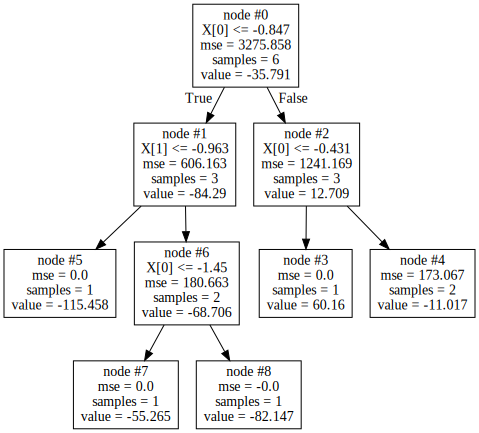

In [52]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None, node_ids=True) 
graph = graphviz.Source(dot_data) 
graph